In [1]:
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.impute import SimpleImputer
import numpy as np 


# 1 - From data lake to data warehouse...

## 1.1 - Merge the .csv files into a single file 
* csv files are in ./data_lake
* the result of the merge operation will be dropped in ./data_warehouse/salaries.csv

In [2]:
# san-francisco-2011.csv
# DONE : use regulare expression instead. The filename format may change later 
def ExtractYear(filename)->int:
  #return int(filename[-8:-4])

  MyRegex = r"20[0-9][0-9]"
  Year = re.search(MyRegex, filename)
  if Year:
    return (int(Year.group()))


In [3]:
col_names = ["EmployeeName",
             "JobTitle",
             "BasePay",
             "OvertimePay",
             "OtherPay",
             "Benefits",
             "TotalPay",
             "PensionDebt",
             "TotalPayBenefits",
             "Year",
             "Notes",
             "Agency",
             "Status"]

col_names_2022 = ["EmployeeName",
                  "JobTitle",
                  "BasePay",
                  "OvertimePay",
                  "OtherPay",
                  "Benefits",
                  "TotalPay",
                  "TotalPayBenefits",
                  "Year",
                  "Notes",
                  "Agency",
                  "Status"]

directory_in = "./assets/data_lake"
directory_out = "/assets/data_warehouse/"
name_out = "salaries.csv"

df = pd.DataFrame()

for path in Path(directory_in).iterdir():
    if path.is_file() and path.suffix == ".csv":
        # Extraire l'année du nom du fichier
        year = ExtractYear(path.name)

        # Tous les fichiers qui datend d'avant 2022 ont une colonne Pension Debt
        if year == 2022:
            # On force le nom des colonnes sans espaces
            current_df = pd.read_csv(path, header=None, skiprows=1, names=col_names_2022)
            # rajouter une colonne PensionDebt entre TotalPay (6) et TotalPayBenefits(7)
            # print(current_df.head())
            current_df.insert(loc=7, column="PensionDebt", value=0)
            #print(current_df.head())
        else:
            # On force le nom des colonnes sans espaces
            current_df = pd.read_csv(path, header=None, skiprows=1, names=col_names)
            
        df = pd.concat([df, current_df])

# Rajout un index
df.insert(0, "Id", list(range(1, len(df) + 1)))

## 1.2 - Data cleaning of the raw data

In [4]:
#df = pd.read_csv("./assets/data_warehouse/salaries.csv")
df.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,PensionDebt,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,0.0,567595.43,NaN,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,0.0,538909.28,NaN,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,0.0,335279.91,NaN,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,0.0,332343.61,NaN,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,0.0,326373.19,NaN,326373.19,2011,NaN,San Francisco,NaN


In [5]:
df.describe(include="all")

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,PensionDebt,TotalPayBenefits,Year,Notes,Agency,Status
count,478960.000000,478960,478960,478960.000000,478960.000000,478960.000000,478960.000000,478960.000000,121553.000000,478960.000000,478960.000000,0.0,478960,286515
unique,NaN,144814,2539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2
top,NaN,Kevin Lee,Transit Operator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,San Francisco,FT
freq,NaN,51,28874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,478960,190040
mean,239480.500000,NaN,NaN,75469.817047,6449.248849,3725.357381,25047.555482,85644.423277,459.950960,110808.707544,2016.649701,NaN,NaN,NaN
std,138263.986802,NaN,NaN,49744.859572,14962.917669,7673.620109,17586.150048,58617.365928,1617.708215,73828.224499,3.404724,NaN,NaN,NaN
min,1.000000,NaN,NaN,-9942.330000,-22453.280000,-7058.590000,-13939.420000,-618.130000,-1.140000,-3628.780000,2011.000000,NaN,NaN,NaN
25%,119740.750000,NaN,NaN,39682.085000,0.000000,0.000000,5883.845000,43499.947500,0.000000,55179.427500,2014.000000,NaN,NaN,NaN
50%,239480.500000,NaN,NaN,73161.025000,4.000000,776.800000,29050.940000,81116.020000,0.000000,108797.740000,2017.000000,NaN,NaN,NaN
75%,359220.250000,NaN,NaN,107167.102500,5801.395000,4312.050000,36926.007500,120376.735000,0.000000,155681.512500,2020.000000,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 478960 entries, 0 to 40902
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                478960 non-null  int64  
 1   EmployeeName      478960 non-null  object 
 2   JobTitle          478960 non-null  object 
 3   BasePay           478960 non-null  float64
 4   OvertimePay       478960 non-null  float64
 5   OtherPay          478960 non-null  float64
 6   Benefits          478960 non-null  float64
 7   TotalPay          478960 non-null  float64
 8   PensionDebt       121553 non-null  float64
 9   TotalPayBenefits  478960 non-null  float64
 10  Year              478960 non-null  int64  
 11  Notes             0 non-null       float64
 12  Agency            478960 non-null  object 
 13  Status            286515 non-null  object 
dtypes: float64(8), int64(2), object(4)
memory usage: 54.8+ MB


In [7]:
df.isna().sum() / len(df) * 100

Id                    0.000000
EmployeeName          0.000000
JobTitle              0.000000
BasePay               0.000000
OvertimePay           0.000000
OtherPay              0.000000
Benefits              0.000000
TotalPay              0.000000
PensionDebt          74.621472
TotalPayBenefits      0.000000
Year                  0.000000
Notes               100.000000
Agency                0.000000
Status               40.179764
dtype: float64

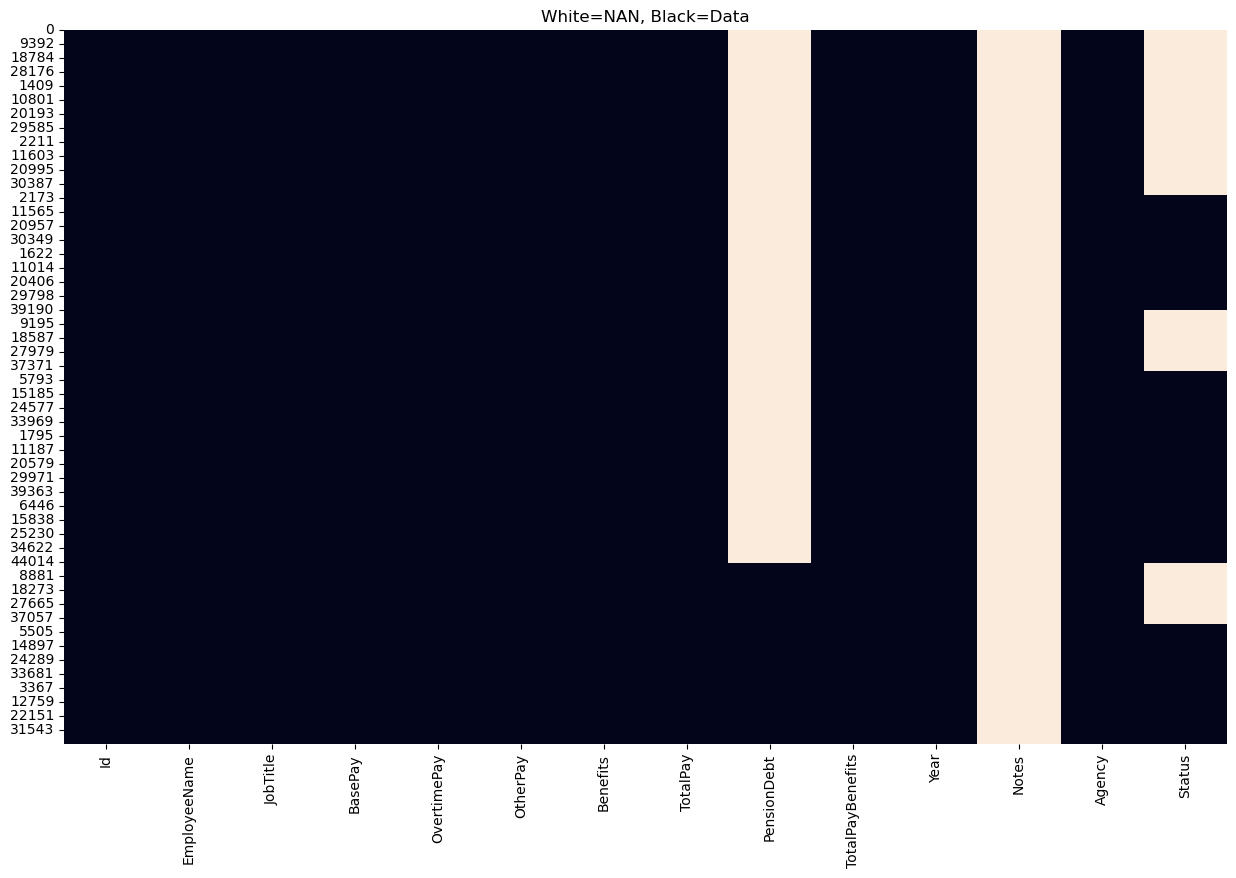

In [8]:
plt.figure(figsize=(15, 15/1.618))
plt.title("White=NAN, Black=Data")
_ = sns.heatmap(df.isna(), cbar=False)

### Comments
* **Notes** should be removed (what can we do with 100% of missing data?)
* Should we remove **Status** ? What can we expect with 40% of missing data?
* **PensionDebt** should be removed (what can we do with 74% of missing data?)

### 1.2.2 - What is the content of the Status feature ?

In [9]:
df["Status"].value_counts(dropna=False)

Status
NaN    192445
FT     190040
PT      96475
Name: count, dtype: int64

* Since we don't know how to replace/fill the missing values

#### `Decision` 
We decide to remove **Status**

### 1.2.3 - What is the content of PensionDebt ?

In [10]:
df["PensionDebt"].value_counts(dropna=False)

PensionDebt
 NaN        357407
 0.00       109683
 5171.67        96
 3591.35        94
 5180.42        89
             ...  
 3635.23         1
 3585.84         1
 3785.22         1
 3386.95         1
-1.14            1
Name: count, Length: 9535, dtype: int64

Is PensionDebt important ?

* It is available since 2020
* Is is used in the evaluation of Total Pay & Benefits

```
Total Pay = Base Pay + Overtime Pay + Other Pay 
Total Pay & Benefits = Total Pay + Benefits + Pension Debt 
```

* If we remove PensionDebt we have to recalcultate Total Pay & Benefits on the corresponding line
* We would be modifying the data 
* However the Total Pay & Benefits before 2020 are correct 

#### `Decision`
* Keep the **PensionDebt** feature

### 1.2.4 - Removal of Notes & Status

In [11]:
df.drop(["Notes", "Status"], axis=1, inplace=True)           # axis 1 = column

In [12]:
df.isna().sum() / len(df) * 100

Id                   0.000000
EmployeeName         0.000000
JobTitle             0.000000
BasePay              0.000000
OvertimePay          0.000000
OtherPay             0.000000
Benefits             0.000000
TotalPay             0.000000
PensionDebt         74.621472
TotalPayBenefits     0.000000
Year                 0.000000
Agency               0.000000
dtype: float64

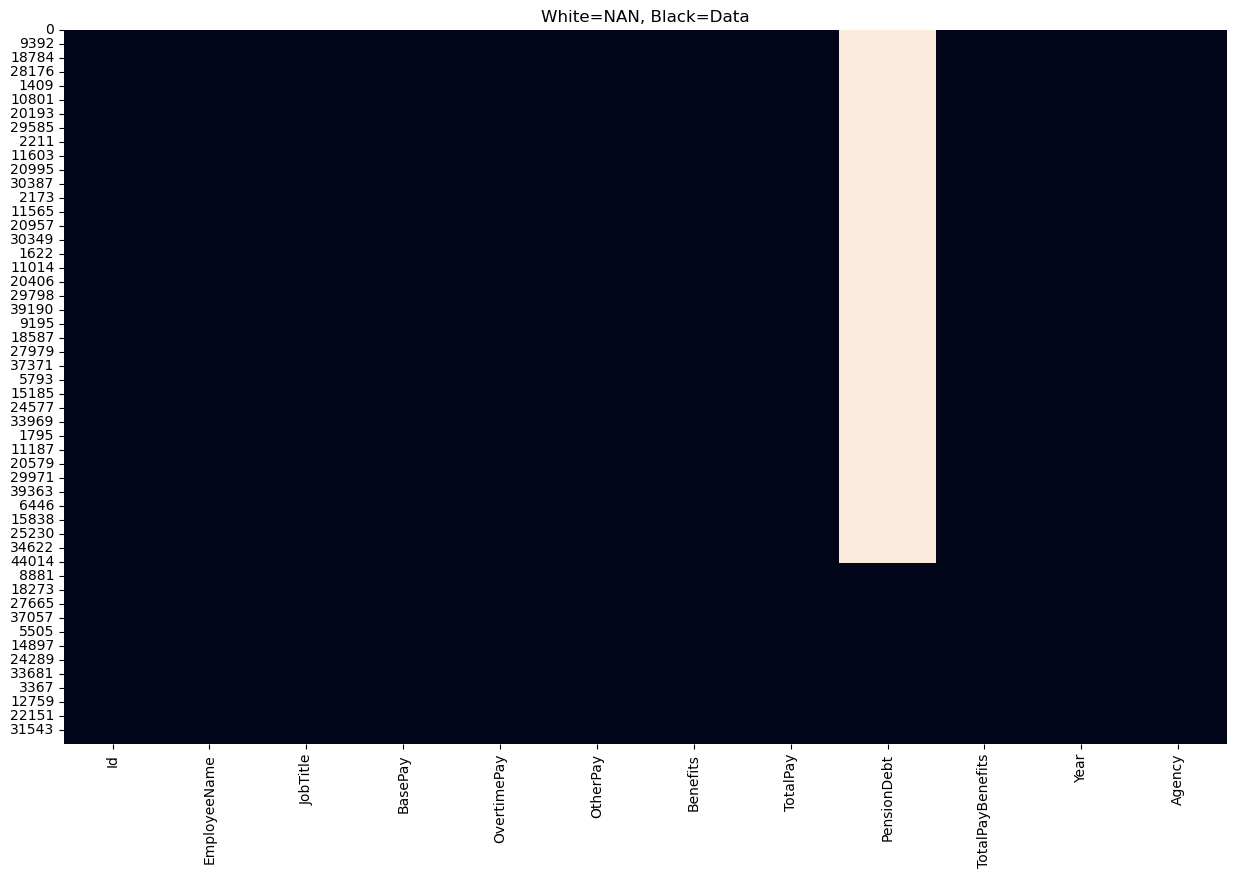

In [13]:
plt.figure(figsize=(15, 15/1.618))
plt.title("White=NAN, Black=Data")
_ = sns.heatmap(df.isna(), cbar=False)

In [14]:
df.shape

(478960, 12)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 478960 entries, 0 to 40902
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Id                478960 non-null  int64  
 1   EmployeeName      478960 non-null  object 
 2   JobTitle          478960 non-null  object 
 3   BasePay           478960 non-null  float64
 4   OvertimePay       478960 non-null  float64
 5   OtherPay          478960 non-null  float64
 6   Benefits          478960 non-null  float64
 7   TotalPay          478960 non-null  float64
 8   PensionDebt       121553 non-null  float64
 9   TotalPayBenefits  478960 non-null  float64
 10  Year              478960 non-null  int64  
 11  Agency            478960 non-null  object 
dtypes: float64(7), int64(2), object(3)
memory usage: 47.5+ MB


### 1.2.5 - Is there any TotalPayBenefits equal to 0 ?

* If yes should we remove these lines or not ?

In [16]:
df["TotalPayBenefits"].value_counts(dropna=False)

TotalPayBenefits
0.00         2447
7959.18       263
250.00         91
1196.00        58
123290.70      56
             ... 
128909.91       1
128916.15       1
128916.80       1
128916.88       1
2.46            1
Name: count, Length: 453533, dtype: int64

There are 2 500 samples overs 480 000.

#### `Decision`
* At this stage we keep the samples with TotalPayBenefits equal to 0
* We will let the rest of the team know about it

### 1.2.6 Summary
* The csv files have been merge into a single file
* A minimum of cleaning has been applied
* The data frame is ready for saving in the in the Data Warehouse directory

## 1.3 - Saving the merged file in the Data Warehouse

### 1.3.1 - CSV file format

In [17]:
directory_out = "/assets/data_warehouse/"
name_out = "salaries.csv"

# __file__ is NOT defined in Jupyter notebook
# current_dir = Path(__file__).parent
current_dir = os.path.abspath("")
filename_out = current_dir + directory_out + name_out

filepath = Path(filename_out)
df.to_csv(filepath, index=False)

### 1.3.2 - Creating a .xslx version of the clean csv file

* It does'nt work as expected
* Slow, very slow 2 min.
* At the end the .xslx file is empty
* You are asked to connect to "**d.docs.live.net**" to open it (???)

![Alt text](assets/images/d_docs_live_net.png)

### `Decision`
* Without any further and strong request from other departments for such file format we will NOT deliver .xlsx file format in the data warehouse


In [18]:
# xlsxwriter must be installed otherwise it takes way too much time

# Uncomment the lines below
# directory_out = "/assets/data_warehouse/"
# name_out = "salaries.xlsx"
# 
# current_dir = os.path.abspath("")
# filename_out = current_dir + directory_out + name_out
# 
# filepath = Path(filename_out)
# 
# MyXlsxWriter = pd.ExcelWriter(filepath, engine = 'xlsxwriter')
# df.to_excel(MyXlsxWriter, float_format = '%.2f')

### 1.3.3 - Creating an sqlite version of the clean csv file

#### 1.3.3.1 - Saving the cleaned file without header in the Data Warehouse
* The code below generate a csv file wichi will consumed by the ./importer.sql

In [19]:
directory_out = "/assets/data_warehouse/"
name_out = "salaries_no_header.csv"

# __file__ is NOT defined in Jupyter notebook
# current_dir = Path(__file__).parent
current_dir = os.path.abspath("")
filename_out = current_dir + directory_out + name_out

filepath = Path(filename_out)
df.to_csv(filepath, index=False, header=False)

### 1.3.3.2 - Creating a sqlite version of the csv file

In order to do so, simply follow the instructions herebelow :

1. Open powershell in the Project/assets/sqlite_converter directory
1. sqlite3.exe and importer.sql files should be there
1. Enter the folowing commands :
```
./sqlite3.exe 
sqlite> .read ./importer.sql
sqlite> .quit
```

The importer.sql is in charge of generating a Salaries.sqlite in the ./data_warehouse subdirectorie.

Here is the content of importer.sql

```sql
.mode csv
.separator ","

CREATE TABLE salaries (
    Id INTEGER PRIMARY KEY,
    EmployeeName TEXT,
    JobTitle TEXT,
    BasePay NUMERIC,
    OvertimePay NUMERIC,
    OtherPay NUMERIC,
    Benefits NUMERIC,
    TotalPay NUMERIC,
    PensionDebt NUMERIC,
    TotalPayBenefits NUMERIC,
    Year INTEGER,
    Agency TEXT);

.import "../data_warehouse/salaries_no_header.csv" salaries
.save "../data_warehouse/salaries.sqlite"
```


At this stage a salaries.sqlite file is available in the Project/assets/data_warehouse directory
* It comes with an `Id` which is used as a primary key
* Data types are OK

![Alt text](assets/images/sqlite_in_vscode.png)

The salaries.sqlite file can be easily used in VSCode for example. See below an example : 

![Alt text](assets/images/select_in_vscode.png)

### 1.3.4 Update of the Data Warehouse on Google Cloud

* A project has been created on Google Cloud (prj-sf-wages)
* It includes a bucket with the ./data_lake and ./data_warehouse
* A copy of the files is available there

![Alt text](assets/images/bucket.png)

A dataset (Big Query) has been created based on the salaries.csv file

![Alt text](assets/images/dataset.png)

The table is available

![Alt text](assets/images/table_on_cloud.png)

SQL statement can be used on the dataset

![Alt text](assets/images/query_cloud.png)



### 1.3.5 Summary
* The csv file is merged and a minimum of cleaning has been applied to the raw data 
* It is available in the local data wharehouse directorie
* A copy of the csv file exists as a sqlite database
    * It can be used directly in VSCode
* If needed one can generate a .xlsx version of the csv file in the data warehouse directorie
* Both files can be shared with others for further analysis
* The respectives directories exist on the Google Cloud project have been updated (manual process so far)

## TO BE DELETED

In [20]:
# Sanity check
# Count the number of lines of the final csv file
directory_in = "./assets/data_lake"
total_len=0

for path in Path(directory_in).iterdir():
    if path.is_file() and path.suffix == ".csv":
      current_df = pd.read_csv(path)
      current_len = len(current_df) 
      total_len += current_len
      print (f"{path.name} : {current_len} {total_len}") 


san-francisco-2011.csv : 36159 36159
san-francisco-2012.csv : 36766 72925
san-francisco-2013.csv : 37606 110531
san-francisco-2014.csv : 38119 148650
san-francisco-2015.csv : 39387 188037
san-francisco-2016.csv : 40970 229007
san-francisco-2017.csv : 41566 270573
san-francisco-2018.csv : 42309 312882
san-francisco-2019.csv : 44525 357407
san-francisco-2020.csv : 40944 398351
san-francisco-2021.csv : 39706 438057
san-francisco-2022.csv : 40903 478960


In [21]:
# import os
# import numpy as np
# import pandas as pd

# data = pd.DataFrame()

# col_names = ["EmployeeName",
#              "JobTitle",
#              "BasePay",
#              "OvertimePay",
#              "OtherPay",
#              "Benefits",
#              "TotalPay",
#              "TotalPayBenefits",
#              "Year",
#              "Notes",
#              "Agency"]


# 2011 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2012 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2013 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2014 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2014 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2015 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2016 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2017 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2018 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2019 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2020 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2021 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Pension Debt,Total Pay & Benefits,Year,Notes,Agency,Status
# 2022 Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,             Total Pay & Benefits,Year,Notes,Agency,Status


# for year in range(2011, 2015):
#     if year==2014:
#         col_names = col_names + ["Status"]
#     year_data = pd.read_csv("input/san-francisco-%d.csv" % year,
#                             header=None,
#                             skiprows=1,
#                             names=col_names)
#     if year==2011:
#         year_data["Benefits"] = np.nan # originally "Not Provided"
#     if year<2014:
#         year_data.insert(year_data.shape[1], "Status", np.nan)
#     data = pd.concat([data, year_data])

# data.insert(0, "Id", list(range(1, len(data)+1)))
# data.to_csv("output/Salaries.csv", index=False)

In [22]:
# import re
# data = "san-francisco-2012.csv"
# #MyRegex = r"^.*20[0-9].*.csv"
# MyRegex = r"20[0-9][0-9]"

# #Voir : https://www.w3schools.com/python/python_regex.asp
# MyList = re.findall(MyRegex, data) 
# print(MyList)

# Year = re.search(MyRegex, data)
# if Year:
#   print(int(Year.group()))
# # print (bool(re.match(MyRegex,data))

### TO DO
* est ce qu'on peut importer dans sqlite en oubliant directement la première ligne du csv ?
    * eviterait de générer un fichier csv sans en-tête
    * risque de désynchronisation entre sql import et ce notebook 
* est ce qu'on peut appeler sqlite3.exe depuis un notebook ?
    * pour convertir le fichier en .sqlite
* ~~Déposer le csv sur Google Cloud~~
    * ~~En faire un dataset interrogeable en SQL~~
* ~~génération xlsx très très lente ? A vérifier~~
* faudrait voir ces histoires de mise à jour automatique de Google Cloud 
~~Ré écrire ExtractYear avec une expression régulière~~
* ~~Générer une version sqlite dans le data_warehouse~~
* ~~Virer les colonnes qui servent à rien~~ 
* ~~Expliquer les choix~~
* ~~Verifier qu'on a bien des nombres à virgule~~
* ~~Comprendre~~
```
Total Pay = Base Pay + Overtime Pay + Other Pay 
Total Pay & Benefits = Total Pay + Benefits + Pension Debt 
```
* ~~Sortir Pension Deb comme % de la ligne ?~~
    * ~~Pas la peine car on le garde~~
* ~~Si on supprime Pension_Debt faut il modifier Total pay et/ou Total Pay & benefit ?~~
    * ~~Oui~~    
* ~~Faire un mini test dans VSCode avec salaries.sqlite~~